In [148]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import plotly.graph_objects as go

In [149]:
with open('/content/input.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['intents'])

In [150]:
df.head(1)

,tag,patterns,responses
0,greeting,"[Hi, Hey, Is anyone there?, Hi there, Hello, H...",[Hello there. Tell me how are you feeling toda...


In [151]:
def map_tag_pattern(df, tag_col, text_col, res_col):
  dic = {tag_col:[], text_col:[], res_col:[]}

  for index, item in df.iterrows():
      ptrns = item[text_col]
      rspns = item[res_col]
      tag = item[tag_col]
      for j in range(len(ptrns)):
          dic[tag_col].append(tag)
          dic[text_col].append(ptrns[j])
          dic[res_col].append(rspns)

  return pd.DataFrame.from_dict(dic)

df = map_tag_pattern(df, "tag", "patterns", "responses")

In [152]:
print(df['tag'].unique(), len(df['tag'].unique()))

['greeting' 'courtesy-greeting' 'morning' 'afternoon' 'evening' 'night'
 'goodbye' 'counter-goodbye' 'thanks' 'no-response' 'neutral-response'
 'about' 'skill' 'creation' 'name' 'help' 'sad' 'stressed' 'worthless'
 'depressed' 'happy' 'casual' 'anxious' 'not-talking' 'not-talking-to-you'
 'sleep' 'scared' 'death' 'no-understand' 'understand' 'clever' 'done'
 'shutup' 'Swearing' 'self-aware' 'suicide' 'gossip' 'hate-you' 'hate-me'
 'default' 'jokes' 'repeat' 'wrong' 'stupid' 'location' 'something-else'
 'friends' 'ask' 'problem' 'no-approach' 'learn-more' 'user-agree'
 'meditation' 'user-meditation' 'pandora-useful' 'user-advice'
 'learn-mental-health' 'mental-health-fact'] 58


In [153]:
import plotly.graph_objects as go

intent_counts = df['tag'].value_counts()
fig = go.Figure(data=[go.Bar(x=intent_counts.index, y=intent_counts.values)])
fig.update_layout(title='Distribution of Intents', xaxis_title='Intents', yaxis_title='Count')
fig.show()

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return plt

In [155]:
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score,confusion_matrix,classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Confusion Matrix
def confusion_matrix_sklearn(predictions, target):
    class_names = np.unique(np.concatenate((predictions, target)))
    cm = confusion_matrix(target, predictions)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [156]:
X = df['patterns']
y = df['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [163]:
class SVCModel:

  def __init__(self, save_model = False, get_best_params = False):

    self.param_grid = {
        'C':[1, 10, 100],
        'gamma':[1, 0.1, 0.001],
        'kernel':['linear','rbf']
    }

    self.grid_search = {}
    self.model = None
    self.save_model = save_model
    self.get_best_params = get_best_params


  def grid_seaarch(self, X_train, y_train):
    # we sample 10k of the dataset to grid search the SVC due to high computatuin time
    np.random.seed(0)
    random_indices = np.random.choice(X_train.shape[0], 10000, replace=False)

    X_train_sampled = X_train[random_indices]
    y_train_sampled = np.array(y_train)[random_indices]

    classifier = SVC(random_state=0)

    self.grid_search = GridSearchCV(estimator = classifier, param_grid = self.param_grid, cv = 5, scoring='accuracy')

    self.grid_search.fit(X_train_sampled, y_train_sampled)


  def fit(self, X_train, y_train):

    if self.get_best_params:
        self.grid_seaarch(X_train, y_train)

    if hasattr(self.grid_search, 'best_params_'):
        print('Best parameters are set: ', self.grid_search.best_params_)
        self.model = SVC(**self.grid_search.best_params_)
    else:
        print('Default parameters are set')
        self.model = SVC(random_state=0)

    self.model.fit(X_train, y_train)

    plot_learning_curve(self.model, "Learning Curve (SVC)", X_train, y_train, cv=5)

    if self.save_model:
      joblib.dump(self.model, '/content/svc.pkl')

    return self.model

  def predict(self, X_test, y_test):
    y_pred = self.model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)

    confusion_matrix_sklearn(y_pred, y_test)

    return y_pred, accuracy, F1, recall, precision

Default parameters are set


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



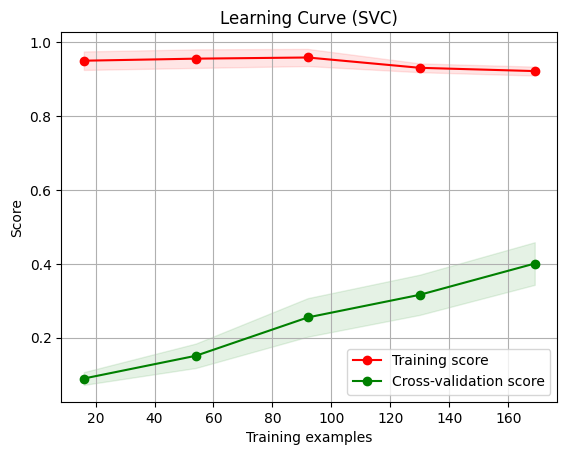

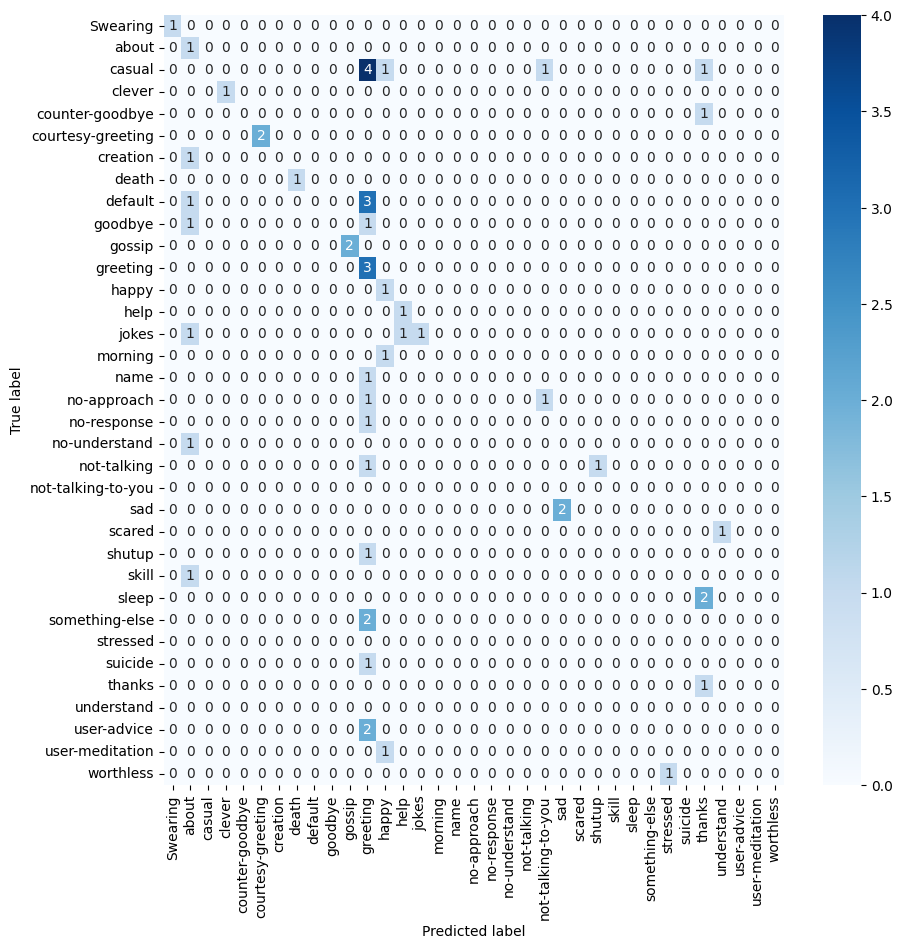

In [164]:
# SVC
sv = SVCModel(save_model = True, get_best_params = False)
model = sv.fit(X_train_vec, y_train)
y_pred, accuracy_sv, F1_sv, recall_sv, precision_sv = sv.predict(X_test_vec, y_test)

In [159]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

report = {label: {metric: report[label][metric] for metric in report[label]} for label in report if isinstance(report[label], dict)}
labels = list(report.keys())

evaluation_metrics = ['precision', 'recall', 'f1-score']
metric_scores = {metric: [report[label][metric] for label in labels] for metric in evaluation_metrics}

fig = go.Figure()
for metric in evaluation_metrics:
    fig.add_trace(go.Bar(name=metric, x=labels, y=metric_scores[metric]))

fig.update_layout(title='Intent Prediction Model Performance',
                  xaxis_title='Intent',
                  yaxis_title='Score',
                  barmode='group')

fig.show()

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import joblib


class LogisticRegressionModel:

  def __init__(self, save_model = False, get_best_params = False):

    self.param_grid = {
      'C': [0.001, 0.01, 0.1, 1, 10, 100],
      'penalty': ['l1', 'l2'],
      'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']
    }

    self.grid_search = {}
    self.best_model = None
    self.model = None
    self.save_model = save_model
    self.get_best_params = get_best_params


  def grid_seaarch(self, X_train, y_train):
    classifier = LogisticRegression()

    self.grid_search = GridSearchCV(estimator=classifier, param_grid=self.param_grid, cv=5, scoring='accuracy')

    self.grid_search.fit(X_train, y_train)

    self.best_model = self.grid_search.best_estimator_

  def fit(self, X_train, y_train):

    if self.get_best_params:
        self.grid_seaarch(X_train, y_train)

    if hasattr(self.grid_search, 'best_params_'):
        print('Best parameters are set: ', self.grid_search.best_params_)
        self.model = LogisticRegression(**self.grid_search.best_params_)
    else:
        print('Default parameters are set')
        self.model = LogisticRegression(random_state=0)

    self.model.fit(X_train, y_train)

    plot_learning_curve(self.model, "Learning Curve (Logistice Regression)", X_train, y_train, cv=5)

    if self.save_model:
      joblib.dump(self.model, '/content/lr.pkl')

    return self.model

  def predict(self, X_test, y_test):
    y_pred = self.model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)

    confusion_matrix_sklearn(y_pred, y_test)

    return accuracy, F1, recall, precision

Default parameters are set


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



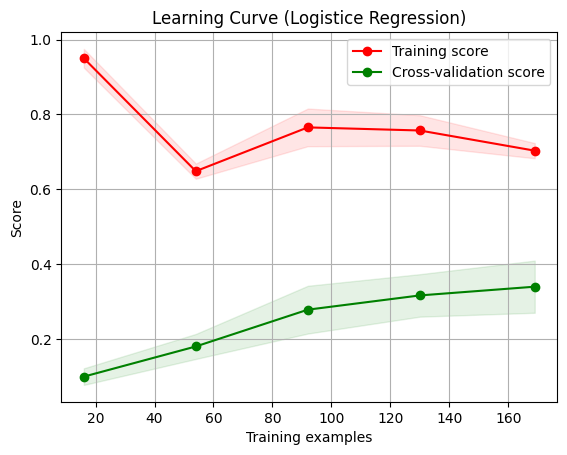

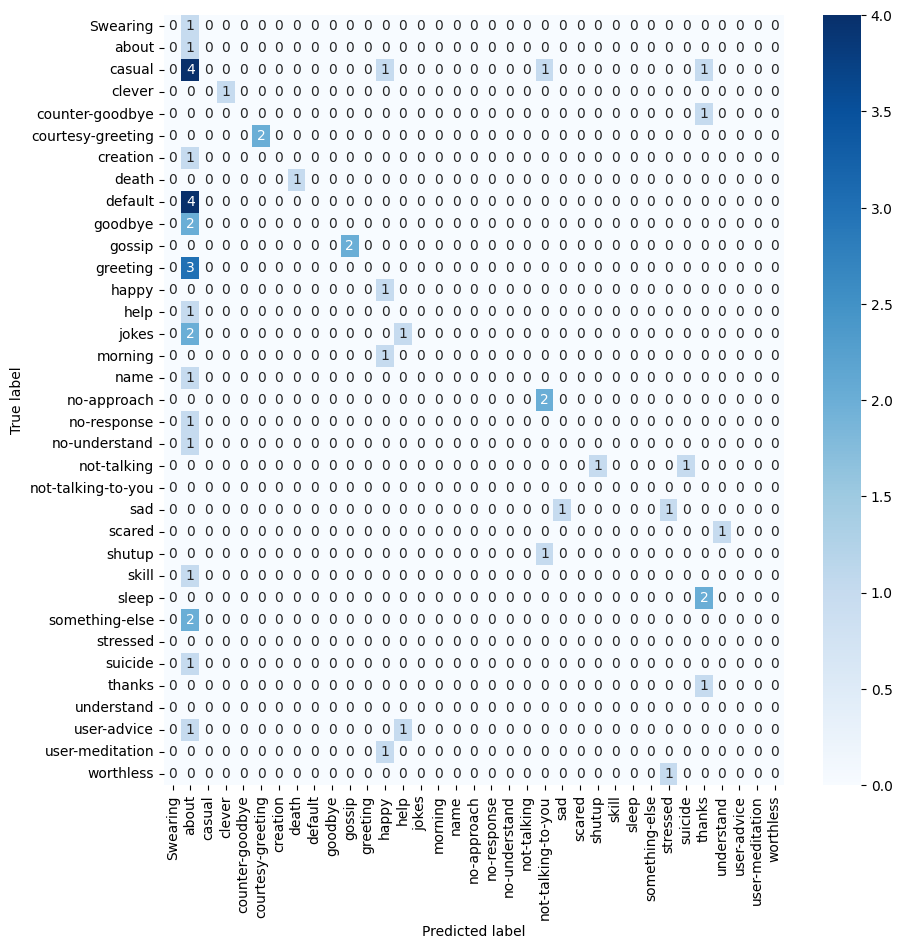

In [161]:
  # logestic regression
  lr = LogisticRegressionModel(save_model = True, get_best_params = False)
  model = lr.fit(X_train_vec, y_train)
  accuracy_lr, F1_lr, recall_lr, precision_lr = lr.predict(X_test_vec, y_test)

In [165]:
import random

# Function to predict the intent
def predict_intent(user_input):
    user_input_vec = vectorizer.transform([user_input])
    intent = model.predict(user_input_vec)[0]
    return intent

# Function to generate a random response based on the intent
def generate_response(intent):
    # print(intent)  # For debugging purposes, to see the intent detected

    # Filter the DataFrame to get the responses for the given intent
    responses = df[df['tag'] == intent]['responses'].values[0]

    # Select a random response
    response = random.choice(responses)
    return response

while True:
    user_input = input("Prompt (press 'q' to quit): ")
    if user_input.lower() == 'q':
        break
    else:
        intent = predict_intent(user_input)
        response = generate_response(intent)
        print("AI:", response)


Prompt (press 'q' to quit): hello
AI: Hello there. Glad to see you're back. What's going on in your world right now?
Prompt (press 'q' to quit): who are you
AI: I'm Pandora, your Personal Therapeutic AI Assistant. How are you feeling today
Prompt (press 'q' to quit): can you tell me a joke
AI: When I was at school people used to throw gold bars at me. I was the victim of bullion.
Prompt (press 'q' to quit): can you explain mental health
AI: I'm Pandora, a Therapeutic AI Assitant designed to assist you. Tell me about yourself.
Prompt (press 'q' to quit): q
